In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/UTKFace.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_

In [3]:
BASE_DIR = '/content/UTKFace'

In [4]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/UTKFace/43_0_0_20170120222409079.jpg....,43,0
1,/content/UTKFace/26_1_2_20170116184248014.jpg....,26,1
2,/content/UTKFace/25_0_0_20170119171142840.jpg....,25,0
3,/content/UTKFace/1_0_4_20161221195419136.jpg.c...,1,0
4,/content/UTKFace/24_1_0_20170117150515251.jpg....,24,1


In [6]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

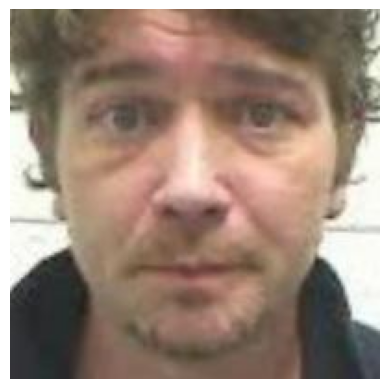

In [7]:
#Exploratory Data Analysis
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

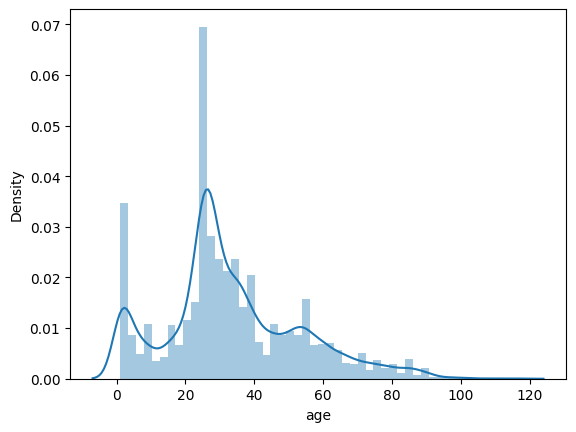

In [8]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

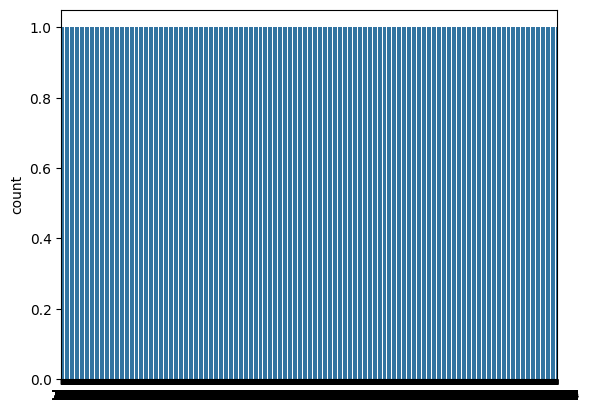

In [9]:
sns.countplot(df['gender'])

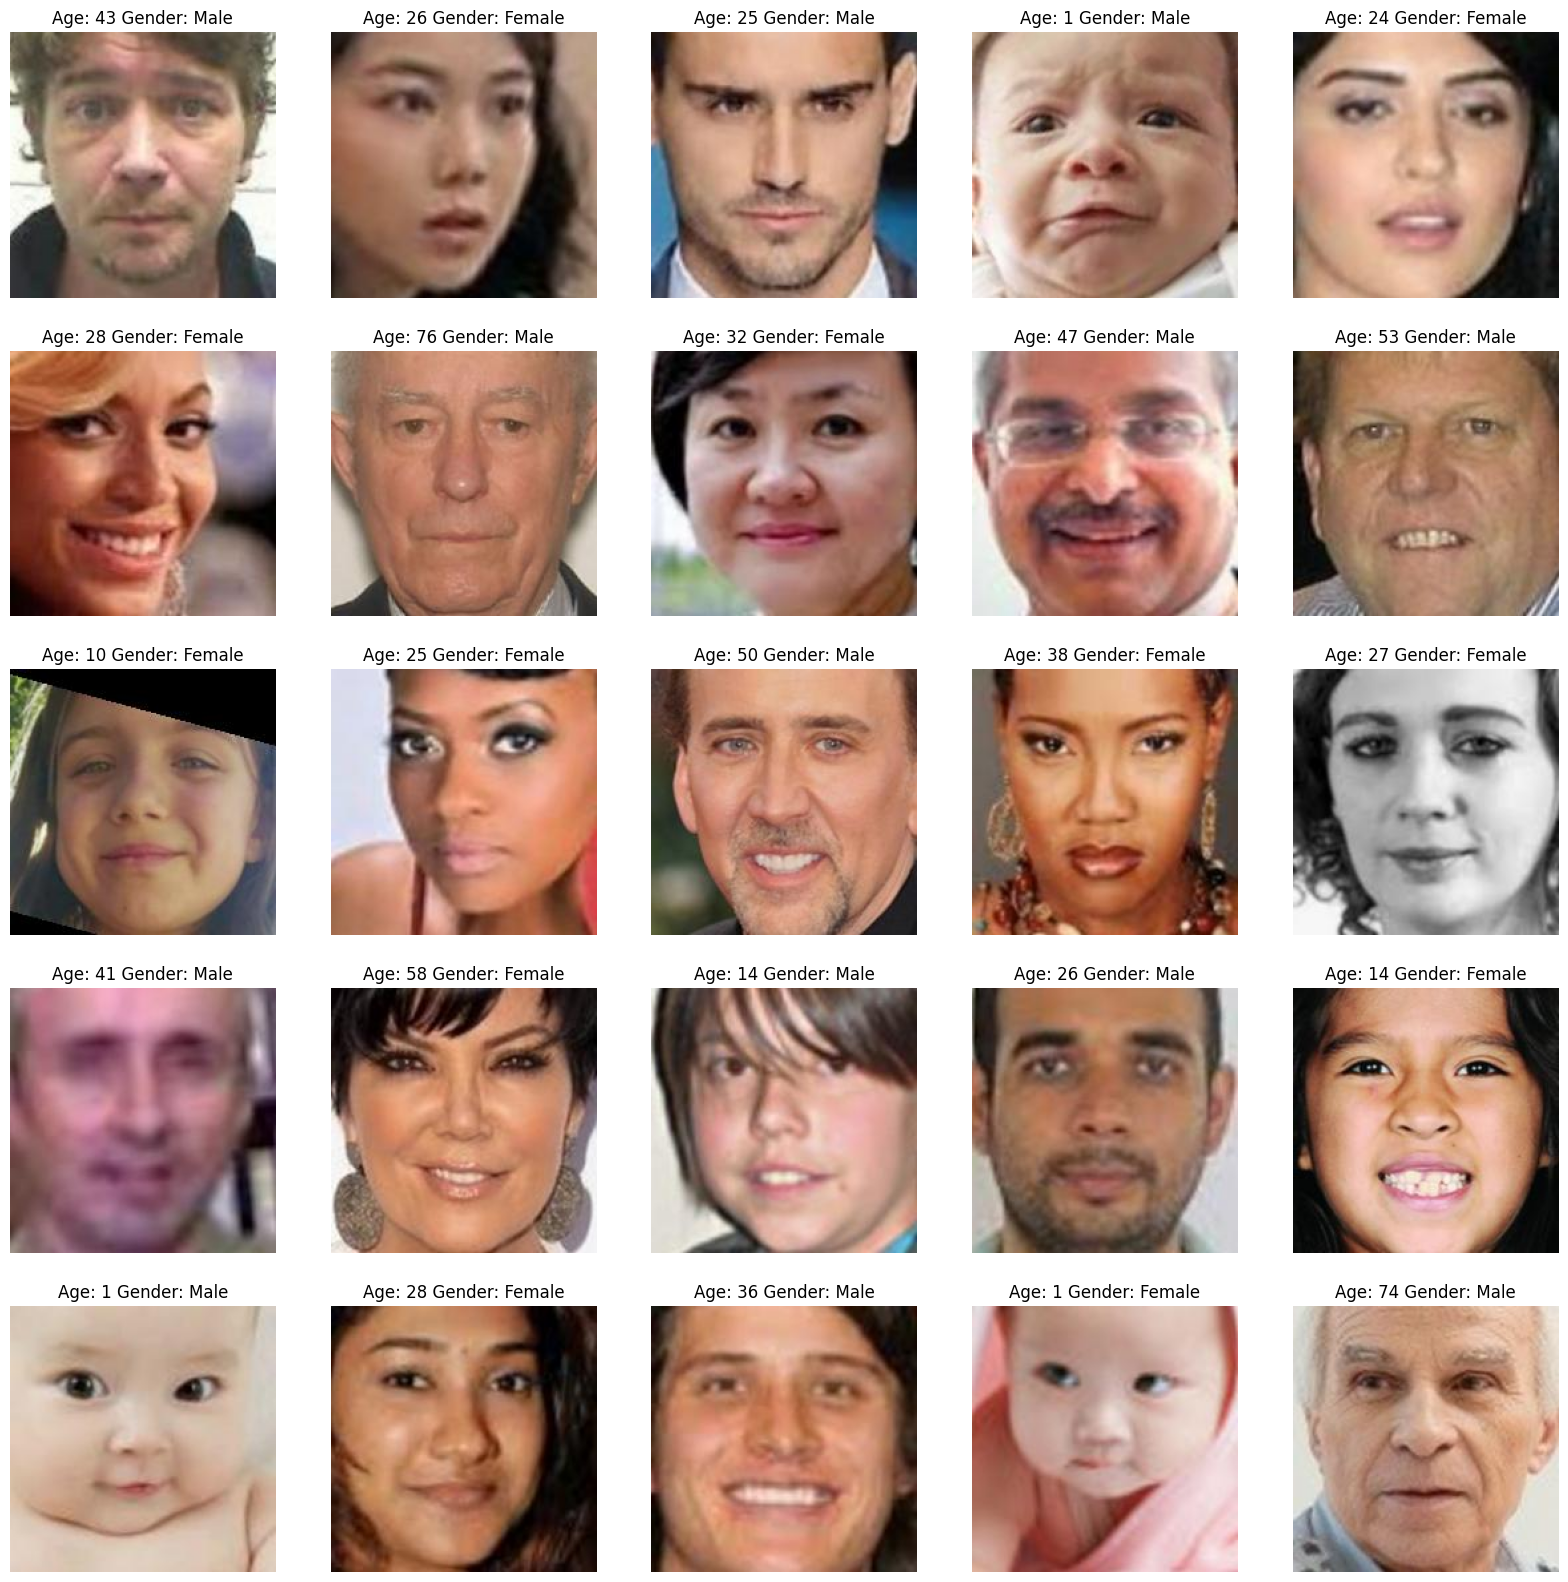

In [10]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [11]:
#Feature Extraction
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        # Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [12]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [13]:
X.shape

(23708, 128, 128, 1)

In [14]:
# normalize the images
X = X/255.0

In [15]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [16]:
input_shape = (128, 128, 1)

In [17]:
#Model Creation
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

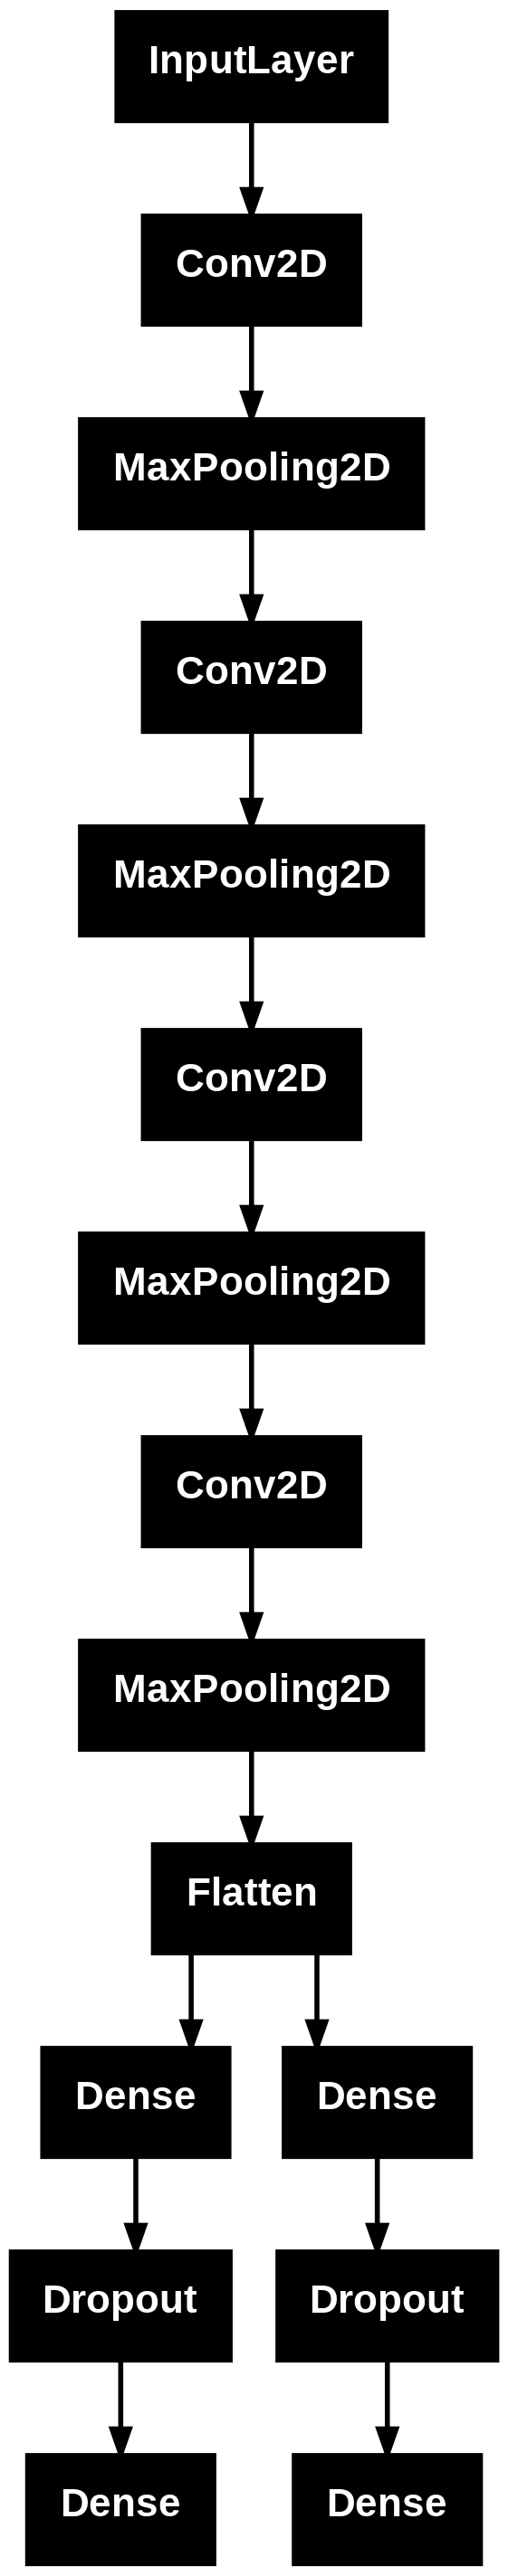

In [18]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - age_out_loss: 16.5206 - age_out_mae: 16.5206 - gender_out_accuracy: 0.5143 - gender_out_loss: 0.7310 - loss: 17.2516 - val_age_out_loss: 13.5977 - val_age_out_mae: 13.6464 - val_gender_out_accuracy: 0.6729 - val_gender_out_loss: 0.6126 - val_loss: 14.2593
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_loss: 12.5837 - age_out_mae: 12.5837 - gender_out_accuracy: 0.7251 - gender_out_loss: 0.5504 - loss: 13.1341 - val_age_out_loss: 9.7716 - val_age_out_mae: 9.7743 - val_gender_out_accuracy: 0.7883 - val_gender_out_loss: 0.4357 - val_loss: 10.2116
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - age_out_loss: 9.9904 - age_out_mae: 9.9904 - gender_out_accuracy: 0.7899 - gender_out_loss: 0.4478 - loss: 10.4383 - val_age_out_loss: 8.2711 - val_age_out_mae: 8.2759 - val_gender_out_accuracy: 0.8161 - val_gender_out_loss: 0.3890 - val_loss: 8.6667
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - age_out_loss: 8

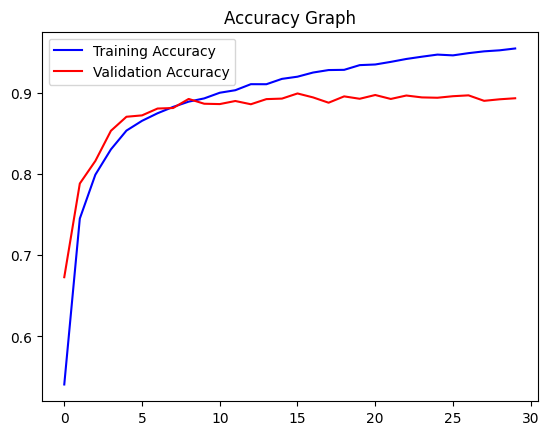

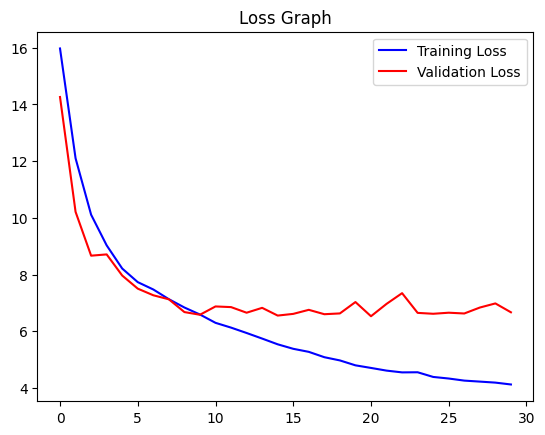

In [20]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

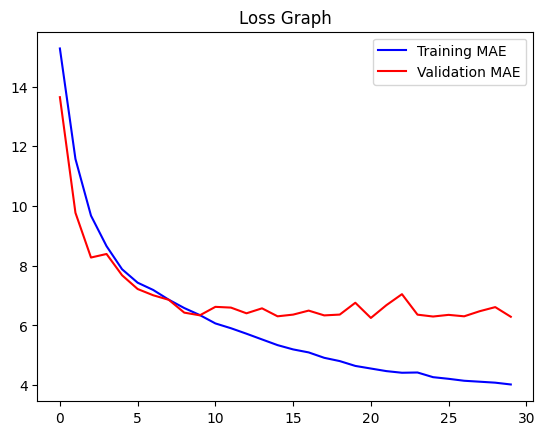

In [21]:
# plot results for age
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Female Original Age: 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicted Gender: Female Predicted Age: 35


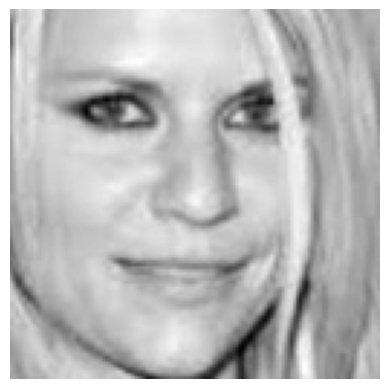

In [22]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Gender: Male Predicted Age: 56


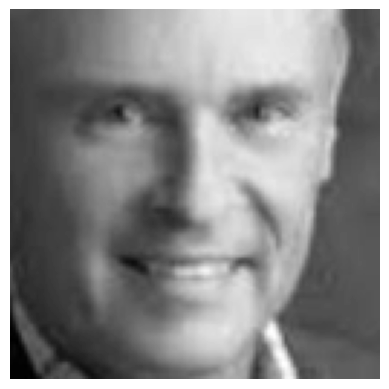

In [23]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Gender: Female Predicted Age: 29


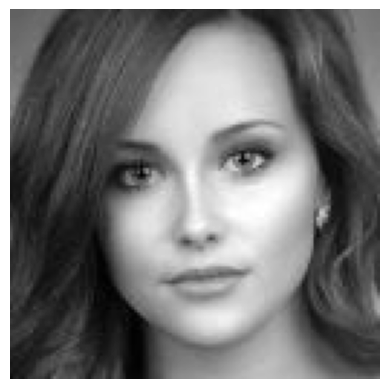

In [24]:
image_path = "/content/wom.jpg"  # Chemin de l'image externe
img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
img = img.resize((128, 128))  # Redimensionner à la taille attendue
img_array = np.array(img) / 255.0  # Normaliser les pixels
img_init_shape = img_array
img_array = img_array.reshape(1, 128, 128, 1)  # Ajouter une dimension batch
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(img_array)
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(img_init_shape, cmap='gray');

In [30]:
# Sauvegarder le modèle au format Keras natif
model.save("trained_model.keras")
print("Modèle enregistré sous le nom trained_model.keras")


Modèle enregistré sous le nom trained_model.keras
